### reference

- https://support.sas.com/documentation//cdl/en/statug/68162/HTML/default/viewer.htm#statug_hpsplit_details06.htm
- https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html#sphx-glr-auto-examples-tree-plot-cost-complexity-pruning-py
- https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html#sphx-glr-auto-examples-tree-plot-unveil-tree-structure-py

### setup

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats

In [4]:
df = pd.read_csv('titanic.csv')
print(df.iloc[0,:].to_string())

survived                 0
pclass                   3
sex                   male
age                   22.0
sibsp                    1
parch                    0
fare                  7.25
embarked                 S
class                Third
who                    man
adult_male            True
deck                   NaN
embark_town    Southampton
alive                   no
alone                False


### split

In [11]:
def entropy(y):
    """Calculate entropy of a binary target array."""
    p1 = np.mean(y)
    p0 = 1 - p1
    if p1 == 0 or p1 == 1:
        return 0
    return -p0 * np.log2(p0) - p1 * np.log2(p1)

def gini(y):
    """Calculate Gini impurity of a binary target array."""
    p1 = np.mean(y)
    p0 = 1 - p1
    return 1 - p0**2 - p1**2

def best_split(df, feature_col, target_col):
    """Find the split point that maximizes information gain."""
    values = np.sort(df[feature_col].unique())
    split_points = (values[:-1] + values[1:]) / 2
    best_gain = -1
    best_split = None
    base_entropy = entropy(df[target_col])
    base_gini = gini(df[target_col])
    for split in split_points:
        left = df[df[feature_col] <= split][target_col]
        right = df[df[feature_col] > split][target_col]
        weighted_entropy = (len(left) * entropy(left) + len(right) * entropy(right)) / len(df)
        weighted_gini = (len(left) * gini(left) + len(right) * gini(right)) / len(df)
        info_gain = base_entropy - weighted_entropy
        gini_gain = base_gini - weighted_gini
        if info_gain > best_gain:
            best_gain = info_gain
            best_split = split
            best_gini_gain = gini_gain
    return best_split, best_gain, best_gini_gain, weighted_gini

In [12]:
split, gain, gini_gain, weighted_gini = best_split(df, 'pclass', 'survived')
print(f"Best split: {split}, Information gain: {gain:.4f}, Gini gain: {gini_gain:.4f}, Weighted Gini: {weighted_gini:.4f}")

Best split: 2.5, Information gain: 0.0758, Gini gain: 0.0491, Weighted Gini: 0.4239


### decision tree

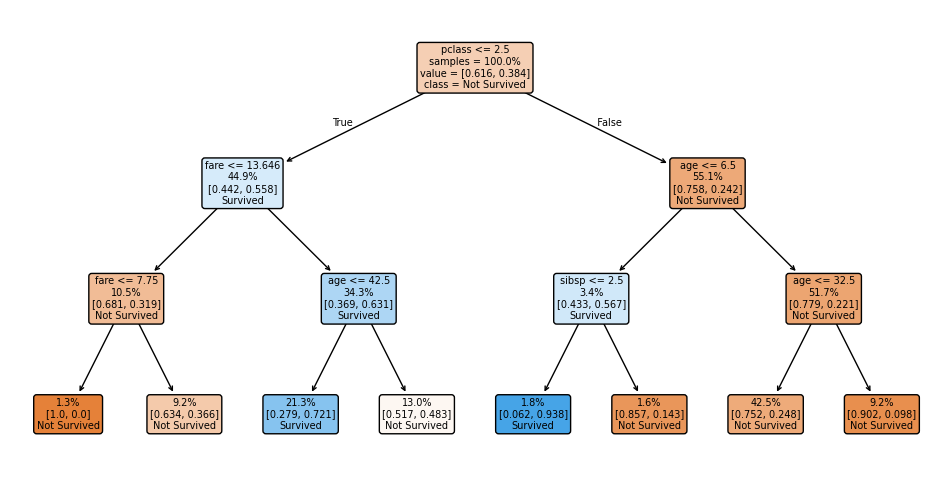

In [59]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Select features and target
features = ['pclass', 'age', 'sibsp', 'parch', 'fare']
X = df[features]
y = df['survived']

# Fit CART model
cart = DecisionTreeClassifier(max_depth=3, random_state=42)
cart.fit(X, y)

# Plot the tree
plt.figure(figsize=(12, 6))
plot_tree(
    cart,
    feature_names=features,
    class_names=['Not Survived', 'Survived'],
    filled=True,
    # node_ids=True,
    impurity=False,
    proportion=True,
    rounded=True,
    label='root',
)
plt.show()

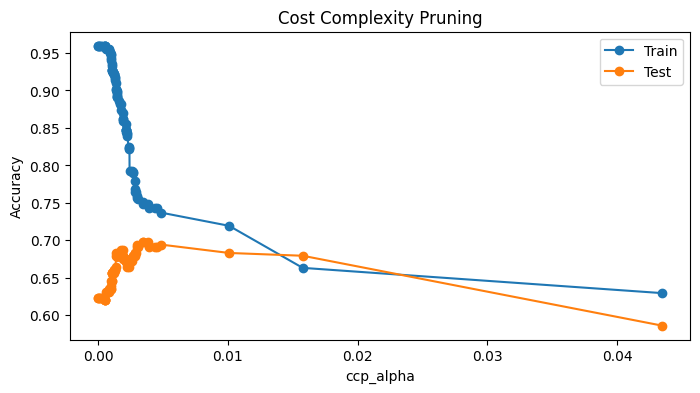

In [62]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split

# Select features and target
features = ['pclass', 'age', 'sibsp', 'parch', 'fare']
X = df[features]
y = df['survived']

# Split data for pruning demonstration
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit initial tree to get ccp_alphas
cart = DecisionTreeClassifier(random_state=42)
path = cart.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas

# Fit trees for each alpha and store their scores
trees = []
train_scores = []
test_scores = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    trees.append(clf)
    train_scores.append(clf.score(X_train, y_train))
    test_scores.append(clf.score(X_test, y_test))

# Plot accuracy vs alpha
plt.figure(figsize=(8, 4))
plt.plot(ccp_alphas, train_scores, marker='o', label='Train')
plt.plot(ccp_alphas, test_scores, marker='o', label='Test')
plt.xlabel("ccp_alpha")
plt.ylabel("Accuracy")
plt.title("Cost Complexity Pruning")
plt.legend()
plt.show()

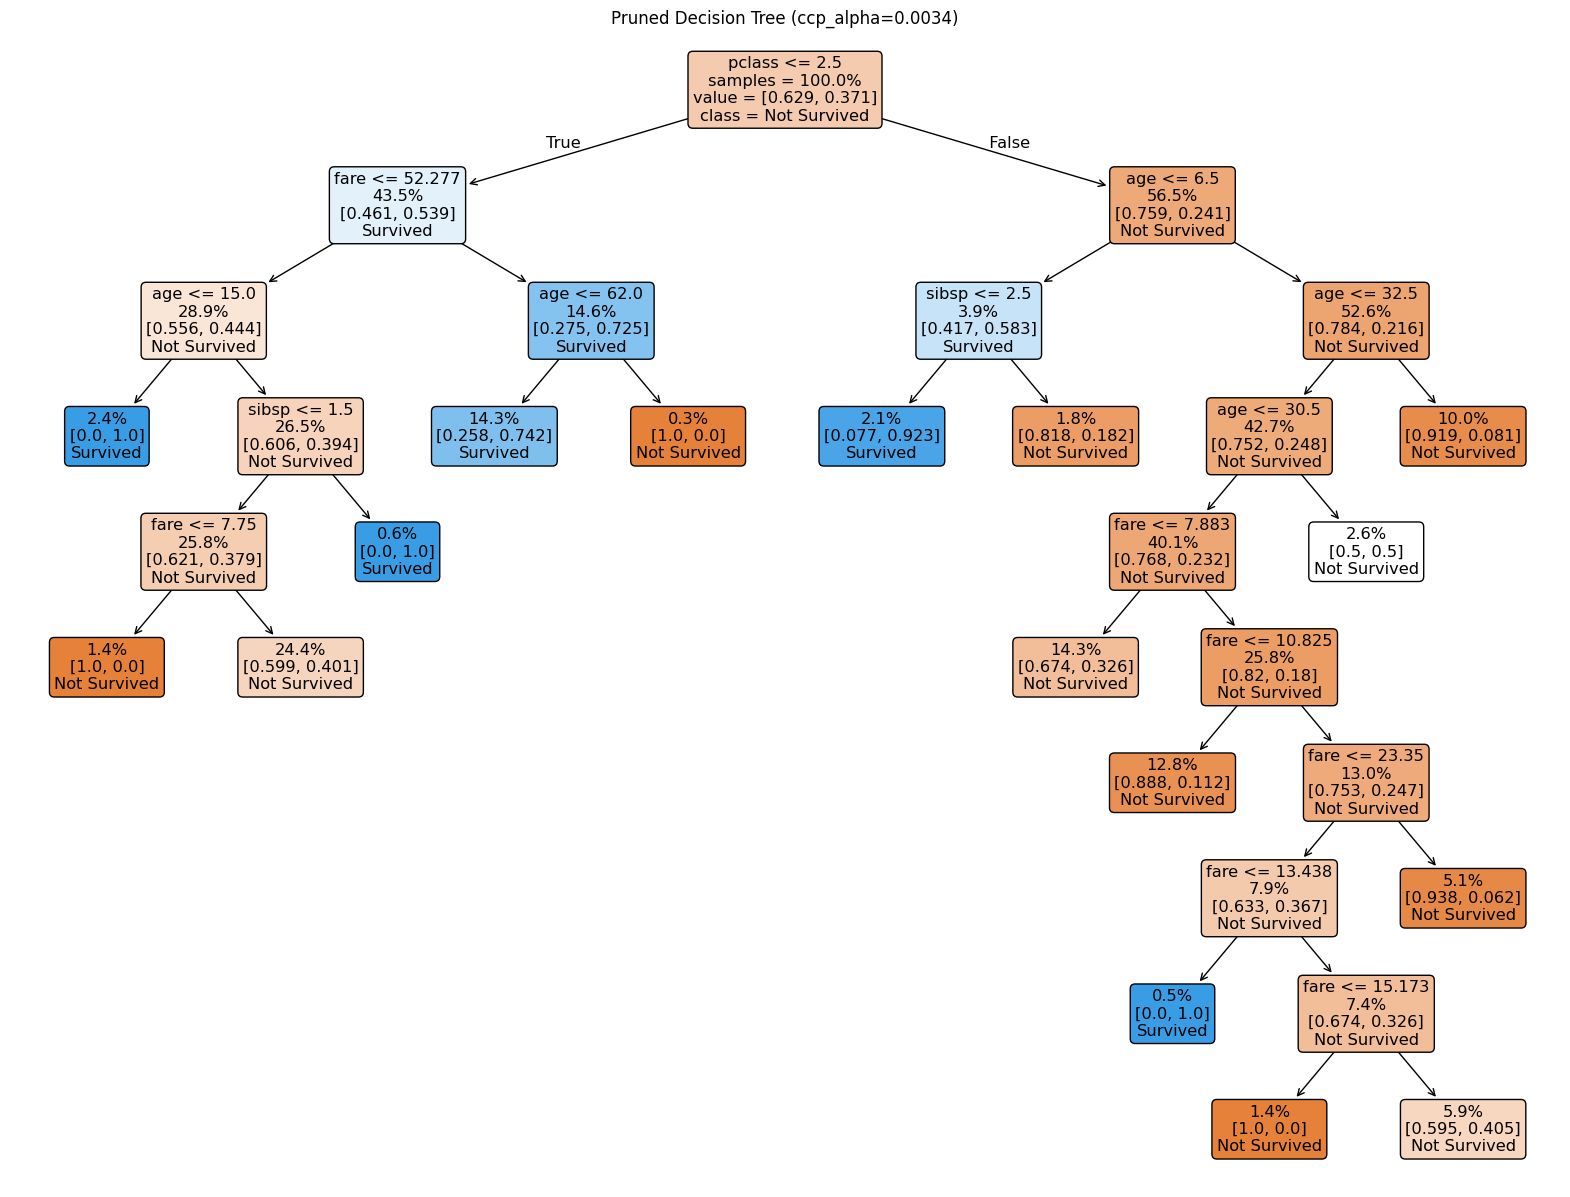

In [67]:
# Choose the best alpha (e.g., the one with highest test score)
best_alpha = ccp_alphas[np.argmax(test_scores)]
pruned_tree = DecisionTreeClassifier(random_state=42, ccp_alpha=best_alpha)
pruned_tree.fit(X_train, y_train)

# Plot the pruned tree
plt.figure(figsize=(20, 15))
plot_tree(
    pruned_tree,
    feature_names=features,
    class_names=['Not Survived', 'Survived'],
    filled=True,
    impurity=False,
    proportion=True,
    rounded=True,
    label='root',
)
plt.title(f"Pruned Decision Tree (ccp_alpha={best_alpha:.4f})")
plt.show()

In [49]:
from sklearn.tree import export_text
r = export_text(cart, feature_names=features)
print(r)

|--- pclass <= 2.50
|   |--- fare <= 13.65
|   |   |--- fare <= 7.75
|   |   |   |--- class: 0
|   |   |--- fare >  7.75
|   |   |   |--- age <= 17.50
|   |   |   |   |--- age <= 16.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- age >  16.50
|   |   |   |   |   |--- class: 1
|   |   |   |--- age >  17.50
|   |   |   |   |--- age <= 26.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- age >  26.50
|   |   |   |   |   |--- class: 0
|   |--- fare >  13.65
|   |   |--- age <= 42.50
|   |   |   |--- age <= 17.50
|   |   |   |   |--- fare <= 135.78
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- fare >  135.78
|   |   |   |   |   |--- class: 1
|   |   |   |--- age >  17.50
|   |   |   |   |--- pclass <= 1.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- pclass >  1.50
|   |   |   |   |   |--- class: 1
|   |   |--- age >  42.50
|   |   |   |--- fare <= 50.74
|   |   |   |   |--- age <= 59.00
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- age >  59.00

In [57]:
# access the tree structure
tree_structure = cart.tree_
print(f"Number of nodes: {tree_structure.node_count}")
print(f"Number of leaves: {tree_structure.n_leaves}")

# access each node's data
for i in range(tree_structure.node_count):
    feature = tree_structure.feature[i]
    threshold = tree_structure.threshold[i]
    if feature != -2:  # -2 means leaf node
        print(f"Node {i}")
        print(f"  Feature: {features[feature]}, Threshold: {threshold:.4f}")
        print(f"  Impurity: {tree_structure.impurity[i]:.4f}, Samples: {tree_structure.n_node_samples[i]}")
        print(f"  Value: {tree_structure.value[i]}")
    else:
        print(f"Node {i}: Leaf node")
        print(f"  Impurity: {tree_structure.impurity[i]:.4f}, Samples: {tree_structure.n_node_samples[i]}")
    print("-" * 40)

Number of nodes: 51
Number of leaves: 26
Node 0
  Feature: pclass, Threshold: 2.5000
  Impurity: 0.4730, Samples: 891
  Value: [[0.61616162 0.38383838]]
----------------------------------------
Node 1
  Feature: fare, Threshold: 13.6459
  Impurity: 0.4934, Samples: 400
  Value: [[0.4425 0.5575]]
----------------------------------------
Node 2
  Feature: fare, Threshold: 7.7500
  Impurity: 0.4346, Samples: 94
  Value: [[0.68085106 0.31914894]]
----------------------------------------
Node 3: Leaf node
  Impurity: 0.0000, Samples: 12
----------------------------------------
Node 4
  Feature: age, Threshold: 17.5000
  Impurity: 0.4640, Samples: 82
  Value: [[0.63414634 0.36585366]]
----------------------------------------
Node 5
  Feature: age, Threshold: 16.5000
  Impurity: 0.3200, Samples: 5
  Value: [[0.2 0.8]]
----------------------------------------
Node 6: Leaf node
  Impurity: 0.0000, Samples: 1
----------------------------------------
Node 7: Leaf node
  Impurity: 0.0000, Samples: